In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from skimage.transform import resize
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [41]:
# Load the CIFAR-10 dataset
(X, y), _ = tf.keras.datasets.cifar10.load_data()

# Split the dataset into train, test, and validation sets
X_train, X_test, _, __ = train_test_split(X, y, test_size=0.2, random_state=42)
___, X_val, _, __ = train_test_split(X_train, _, test_size=0.25, random_state=42)


In [42]:
X_train=X_train/255
X_test=X_test/255
X_val=X_val/255

Having all values be between 0 and 1 allows us to use the sigmoid activation function in the last layer. ReLU would also work if it was capped at 255, but it's not.

In [43]:
desired_width,desired_height = 16, 16

# Define the downsampling function
def downsample_image(image):
    resized = resize(image, (desired_height, desired_width))
    return np.repeat(np.repeat(resized, 2, axis=0), 2, axis=1)
downsample_vectorized = np.vectorize(downsample_image, signature='(n,m,k)->(p,q,r)')


This code simulates donwsizing an image.

In [44]:
x_train_downsampled = downsample_vectorized(X_train)
x_test_downsampled = downsample_vectorized(X_test)
x_val_downsampled = downsample_vectorized(X_val)


In [45]:
class SuperResolution(Model):
  def __init__(self):
    super(SuperResolution, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(32, 32, 3)),
      layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=1),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=1)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(16, kernel_size=3, strides=1, activation='relu', padding='same'),
      layers.Conv2DTranspose(32, kernel_size=3, strides=1, activation='relu', padding='same'),
      layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    return self.decoder(self.encoder(x))

autoencoder = SuperResolution()

In [46]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.fit(x_train_downsampled, X_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_val_downsampled, X_val))

Epoch 1/10
1250/1250 [==============================] - 306s 244ms/step - loss: 0.0046 - val_loss: 0.0026
Epoch 2/10
1250/1250 [==============================] - 310s 248ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 3/10
1250/1250 [==============================] - 308s 247ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 4/10
1250/1250 [==============================] - 306s 245ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 5/10
1250/1250 [==============================] - 307s 246ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 6/10
1250/1250 [==============================] - 310s 248ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 7/10
1250/1250 [==============================] - 305s 244ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 8/10
1250/1250 [==============================] - 308s 246ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 9/10
1250/1250 [==============================] - 308s 246ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 10/10
1250/1250 [=======================

In [47]:
decoded_imgs = autoencoder.predict(x_test_downsampled)


313/313 [==============================] - 23s 74ms/step


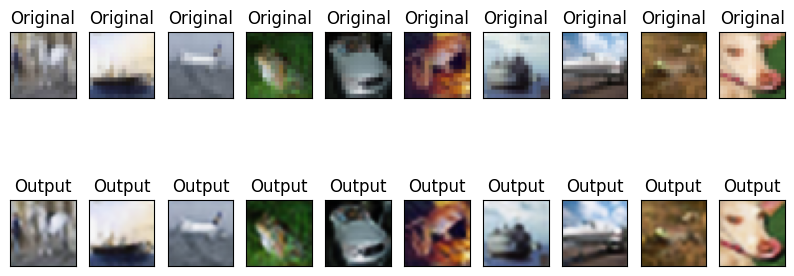

In [48]:
n = 4
plt.figure(figsize=(10, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.title("Original")
    plt.imshow(tf.squeeze((x_test_noisy_colour[i] * 255).astype(int)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(2, n, i + n + 1)
    plt.title("Output")
    plt.imshow(tf.squeeze((decoded_imgs[i] * 255).astype(int)))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

We see it does quite a good job on the images, the dog, car, and horses are much clearer. For the ship (second image) it doesn't seem to do a very good job, but the image itself is quite unclear.